# DeMetRA - literature review

This the preprocessing pipeline for the metadata included in the DeMetRA review. Inputs to the pipeline are: 
- The `MPS_review_systematic_DATE.xlsx` file, which contains the metadata manually extracted by Isabel 
- The bibliography file, to supplement more information about the publications included in the review.

In [3]:
import pandas as pd
assets_directory = '../assets/'

In the file created by Isabel, there are 3 sheets:
1. The main list of MPSs / papers included in the review
2. The base sample references papers for summary statistics 
3. The base sample references papers for validated algorithms 


In [ ]:
sys_review_file = 'MPS_review_systematic_2025-05-06.xlsx' # 'MPS_review_systematic_2025-02-14.xlsx'

lit, base_ss, base_va = pd.read_excel(f'{assets_directory}{sys_review_file}', sheet_name=[0, 1, 2]).values()

# lit = lit.loc[lit.Include == 'Yes'].drop('Include', axis=1) # All included

# print(lit.shape, '\n', list(lit.columns))
# print(base_ss.shape, '\n', list(base_ss.columns))
# print(base_va.shape, '\n', list(base_va.columns))


/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)
/Users/Serena/Desktop/DEMETRA/DeMetRA-review/demetra_venv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Data Validation extension is not supported and will be removed
  warn(msg)


### STEP 1 - Data cleaning

In [ ]:
from dateutil.parser import parse as parse_date

#### Data inspection and cleaning

In [27]:
# Inspect values 
def checklvl(var):
    allobs = pd.concat([lit[var], base_ss[var], base_va[var]])
    print(allobs.value_counts(dropna=False))

for v in  ['Tissue', 'Array','Ancestry','Developmental_period']:
    checklvl(v)
    print('\n')
    try: 
        checklvl(f'Multiple_{v.lower()}')
        print('\n')
    except:
        pass

# NOTE: this is to guide manual cleaning of the excel file!

NameError: name 'lit' is not defined

In [ ]:
# Recode "multiple" categories
def replace_multiples(df):

    for var in ['Tissue', 'Array', 'Ancestry']:
    
        if var == 'Ancestry':
            df.loc[df[var] == 'Multiple', var] = 'Mixed'
    
        else:
            df.loc[df[var] == 'Multiple', var] = [f'Multiple ({values})' for values in df.loc[df[var] == 'Multiple', f'Multiple_{var.lower()}']]
        
        # print(df[var].value_counts(), '\n')
    
    return df

lit = replace_multiples(lit)

In [ ]:
lit.head(3)

,Identifier,Type,Author,Year,Title,Journal,DOI,Include,pdf,Sample_size_total,...,Including_CpGs_4,Including_CpGs_5,Number of CpGs,Determining_weights_1,Train_test,Independent_validation,Comparison,Missing_value_note,Reflect_phenotype,Link
0,1,Journal Article,S. Abrishamcar; J. Chen; D. Feil; A. Kilanowsk...,2022,DNA methylation as a potential mediator of the...,Transl Psychiatry,10.1038/s41398-022-02195-3,Yes,Abrishamcar (2022) - DNA methylation as a pote...,262,...,NaN,NaN,Not reported,Discovery EWAS | linear regression,No,No,No,Not reported,Reported | Explained variance | R = 0.0006,http://dx.doi.org/10.1038/s41398-022-02195-3_x...
1,1,Journal Article,S. Abrishamcar; J. Chen; D. Feil; A. Kilanowsk...,2022,DNA methylation as a potential mediator of the...,Transl Psychiatry,10.1038/s41398-022-02195-3,Yes,Abrishamcar (2022) - DNA methylation as a pote...,262,...,NaN,NaN,Not reported,Discovery EWAS | linear regression,No,No,No,Not reported,Reported | Explained variance | R2 = 0.23,http://dx.doi.org/10.1038/s41398-022-02195-3_x...
2,4,Journal Article,R. Alfano; D. Zugna; H. Barros; M. Bustamante;...,2023,Cord blood epigenome-wide meta-analysis in six...,BMC Med,10.1186/s12916-022-02685-7,Yes,Alfano (2023) - Cord blood epigenome-wide meta,2003,...,NaN,NaN,140,Machine learning | Random forest,Split 20/80%,No,No,Imputed | missForest,Reported | AUC | 0.61 (95% CI= 0.55–0.68),https://www.embase.com/search/results?subactio...


####  Bibliography file
I additionally parse the bibliography file for publication dates, abstracts and keywords

In [ ]:
# Parsing bibliography file (this shoud be a RIS or TXT file in RIS format)

ris_tags = {
    'TY': 'Reference Type',
    'AU': 'Author_list',
    'PY': 'Year',
    'TI': 'Title', # 'T1
    'T2': 'Journal', # 'JO'
    'J2': 'Journal', # For pre-prints 
    'AB': 'Abstract',
    'DO': 'DOI',
    'UR': 'URL',
    'KW': 'Keywords',
    'DA': 'Date'
}

def parse_ris(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        references = []

        current_entry = {}
        current_tag = None

        for line in file:
            if not line.strip():  # Skip empty lines
                continue
            elif line.strip() == 'ER  -':  # ER marks the end of the record
                # Append reference and reset
                references.append(current_entry)
                current_entry = {}
                current_tag = None 
            else:
                tag = line[:5]

                if tag in [f'{t}  -' for t in ris_tags.keys()]:
                    current_tag = tag

                    value = line[5:].strip()
                    key = ris_tags[tag[:2]]

                    if key in current_entry:
                        if isinstance(current_entry[key], list):
                            current_entry[key].append(value)
                        else:
                            current_entry[key] = [current_entry[key], value]
                    else:
                        current_entry[key] = value

                # Handle dates that span multiple lines
                elif tag in [f'{y}-' for y in range(2000, 2025)]:
                    value = line.strip()
                    if 'Date' not in current_entry:
                        current_entry['Date'] = value # Only keep first occurrance (i.e. publication date)

                # Handle keywords that span multiple lines
                else:
                    if current_tag == 'KW  -':
                        value = line.strip()
                        if isinstance(current_entry['Keywords'], list):
                            current_entry['Keywords'].append(value)
                        else:
                            current_entry['Keywords'] = [current_entry['Keywords'], value]
                                    
        return references


parsed_data = parse_ris(f'{assets_directory}Bibliography_2024-09-19.txt')
bib = pd.DataFrame(parsed_data)[['Author_list', 'Year', 'Title', 'Journal', 'Keywords', 'Abstract', 
                                 'Date', 'DOI', 'URL']]

print(bib.shape)
bib.head(3)


(323, 9)


,Author_list,Year,Title,Journal,Keywords,Abstract,Date,DOI,URL
0,"[Abrishamcar, S., Chen, J., Feil, D., Kilanows...",2022,DNA methylation as a potential mediator of the...,Transl Psychiatry,NaN,Prenatal tobacco exposure (PTE) and prenatal a...,09 30,10.1038/s41398-022-02195-3,http://dx.doi.org/10.1038/s41398-022-02195-3
1,"[Ács, O., Péterfia, B., Hollósi, P., Luczay, A...",2017,Methylation Status of CYP27B1 and IGF2 Correla...,Obes Facts,"[25 hydroxyvitamin D, bisulfite, cytochrome P4...",Objective: Worldwide increasing childhood obes...,2017-08-16,10.1159/000477462,https://www.embase.com/search/results?subactio...
2,"[Adcock, R., Nedjai, B., Lorincz, A. T., Scibi...",2022,DNA methylation testing with S5 for triage of ...,Int J Cancer,"[adolescent, adult, aged, article, biopsy, can...",Methylation of host and viral genes is promisi...,2022-06-27,10.1002/ijc.34050,https://www.embase.com/search/results?subactio...


In [ ]:
# Clean bibliography file

# Only selected papers ----------------------------------------------------------------
bib_incl = bib.loc[bib.Title.isin(lit.Title.unique()), ].reset_index(drop=True)
# bib_incl.shape

# Correct dates ----------------------------------------------------------------------- 
print('Note', bib_incl.Date.isna().sum(), 'NaN Date values will be set to 01/01 of respective year')

date_tmp = pd.Series([' '.join([d, y]) if y not in d else d for d, y in 
                   zip(bib_incl.Date.map(str), bib_incl.Year.map(str))])

bib_incl.loc[:, 'Date'] = date_tmp.apply(lambda date: 
                                         parse_date(date).strftime('%Y-%m-%d') if 'nan' not in date else 
                                         parse_date('01 01' + date[3:]).strftime('%Y-%m-%d'))

# Get Short Author titles ------------------------------------------------------------
bib_incl['Author'] = [f'{fa[0].split(",")[0]} et al.' if len(fa) > 1 else f'{fa[0].split(",")[0]}' 
                            for fa in bib_incl['Author_list']]


# Fix missing Journal names ----------------------------------------------------------
bib_incl.loc[bib_incl.DOI.str.contains('10.3390/toxics9100262', na=False), 
             'Journal'] = 'Toxics'
bib_incl.loc[bib_incl.DOI.str.contains('10.1007/s00787-024-02390-1', na=False), 
             'Journal'] = 'Eur Child Adolesc Psych'
bib_incl.loc[bib_incl.DOI.str.contains('10.3390/ijms22031111|10.3390/ijms22168611', na=False), 
             'Journal'] = 'Int J Mol Sci'

bib_incl.head(5)


Note 9 NaN Date values will be set to 01/01 of respective year


,Author_list,Year,Title,Journal,Keywords,Abstract,Date,DOI,URL,Author
0,"[Abrishamcar, S., Chen, J., Feil, D., Kilanows...",2022,DNA methylation as a potential mediator of the...,Transl Psychiatry,NaN,Prenatal tobacco exposure (PTE) and prenatal a...,2022-09-30,10.1038/s41398-022-02195-3,http://dx.doi.org/10.1038/s41398-022-02195-3,Abrishamcar et al.
1,"[Al-Jawahiri, R., Foroutan, A., Kerkhof, J., M...",2022,SOX11 variants cause a neurodevelopmental diso...,Gen Med,"[nucleic acid genotyping array kit, growth dif...",Purpose: This study aimed to undertake a multi...,2022-04-05,10.1016/j.gim.2022.02.013,https://www.embase.com/search/results?subactio...,Al-Jawahiri et al.
2,"[Alfano, R., Zugna, D., Barros, H., Bustamante...",2023,Cord blood epigenome-wide meta-analysis in six...,BMC Med,"[aurora C kinase, long untranslated RNA, ACTG1...",Background: Rapid postnatal growth may result ...,2023-01-17,10.1186/s12916-022-02685-7,https://www.embase.com/search/results?subactio...,Alfano et al.
3,"[Aref-Eshghi, E., Bend, E. G., Colaiacovo, S.,...",2019,Diagnostic Utility of Genome-wide DNA Methylat...,Am J Hum Genet,"[genomic DNA, adult, article, case report, chi...",Conventional genetic testing of individuals wi...,2019-04-05,10.1016/j.ajhg.2019.03.008,https://www.embase.com/search/results?subactio...,Aref-Eshghi et al.
4,"[Aref-Eshghi, E., Kerkhof, J., Pedro, V. P.]",2020,Evaluation of DNA methylation episignatures fo...,The American Journal of …,NaN,NaN,2020-01-01,NaN,NaN,Aref-Eshghi et al.


In [ ]:
print(lit.shape)

lit_main = lit.rename(columns={'Author': 'Author_dirty',
                               'Journal': 'Journal_dirty'}).merge(bib_incl,
                     on='Title', how='left', suffixes=['','_BIB'])

# CHECKUPS 
# lit_main[['Author','Author_list','Author_dirty']]
# np.where(lit_main['Year'].map(int) != lit_main['Year_BIB'].map(int))
# pd.set_option('display.max_rows', None)
# lit_main.loc[lit_main['DOI'].map(str) != lit_main['DOI_BIB'].map(str), ['Title','DOI','DOI_BIB']]

# Clean DOI values -------------------------------------------------------------------
lit_main['DOI_BIB'] = lit_main['DOI_BIB'].fillna(lit_main['DOI'])
lit_main['DOI'] = lit_main['DOI_BIB']
lit_main.drop(['DOI_BIB','Year_BIB'], axis=1, inplace=True)

(760, 40)


In [ ]:
# Removing 2 scores that have Number of CpGs == 0 because they did not identify a solution
lit_main = lit_main[lit_main['Number of CpGs'] != 0].reset_index(drop=True)

In [ ]:
print(lit_main.shape)
print(lit_main.columns)

# Save cleaned data ------------------------------------------------------------------
lit_main.to_csv(f'{assets_directory}MPS_literature_cleaned.csv', index=False)

(758, 47)
Index(['Identifier', 'Type', 'Author_dirty', 'Year', 'Title', 'Journal_dirty',
       'DOI', 'Include', 'pdf', 'Sample_size_total', 'Sample_size_control',
       'Sample_size_case', 'Sample_type', 'Category', 'Phenotype',
       'What_is_available', 'Identifier_base', 'Multiple_identifier_base',
       'Tissue', 'Multiple_tissue', 'Array', 'Multiple_array', 'Ancestry',
       'Multiple_ancestry', 'Developmental_period', 'Covariates',
       'Sample_overlap_target_base', 'Including_CpGs_1', 'Including_CpGs_2',
       'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5',
       'Number of CpGs', 'Determining_weights_1', 'Train_test',
       'Independent_validation', 'Comparison', 'Missing_value_note',
       'Reflect_phenotype', 'Link', 'Author_list', 'Journal', 'Keywords',
       'Abstract', 'Date', 'URL', 'Author'],
      dtype='object')


In [ ]:
base_ss = replace_multiples(base_ss)
base_va = replace_multiples(base_va)

base_ss.insert(1, 'base_use', 'Summary statistics')
base_va.insert(1, 'base_use', 'Validated algorithm')

print(base_ss.shape, base_va.shape)

lit_base = pd.concat([base_ss, base_va], axis=0, ignore_index=True, sort=False)

print(lit_base.shape)
print(lit_base.columns)

# Save cleaned data ------------------------------------------------------------------
lit_base.to_csv(f'{assets_directory}MPS_base_samples_cleaned.csv', index=False)


(20, 13) (150, 33)
(170, 33)
Index(['Identifier', 'base_use', 'Category', 'Phenotype', 'Link', 'Tissue',
       'Multiple_tissue', 'Array', 'Multiple_array', 'Ancestry',
       'Multiple_ancestry', 'Developmental_period', 'Covariates',
       'Sample_size_total', 'Sample_size_control', 'Sample_size_case',
       'Sample_type', 'What_is_available', 'Identifier_base',
       'Multiple_identifier_base', 'Sample_overlap_target_base',
       'Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3',
       'Including_CpGs_4', 'Including_CpGs_5', 'Number of CpGs',
       'Determining_weights_1', 'Train_validate', 'Independent_test',
       'Comparison', 'Missing_value_note', 'Reflect_phenotype'],
      dtype='object')


### STEP 2 - Descriptives

In [4]:
lit_main = pd.read_csv(f'{assets_directory}MPS_literature_cleaned.csv')

data = lit_main

# Aggregate rows by publication

def aggregate_values(series):
    unique_values = series.unique()
    if len(unique_values) == 1:
        return unique_values[0]
    else:
        return list(unique_values)

# Group by 'Title' and apply the custom aggregation function
glit = lit_main.groupby('Title').agg(aggregate_values).reset_index()
n_MPS = lit_main.Title.value_counts() 
for t in n_MPS.index:
    glit.loc[glit.Title == t, 'n_MPS'] = int(n_MPS[t])

### General descriptives 

In [ ]:
# Add a column for the percentage of all titles
total_titles = data['Title'].nunique()

print('Total number of publications:', total_titles)
print('Total number of unique MPSs:', data.shape[0])

pubs_count = data.groupby('What_is_available')['Title'].nunique().reset_index().set_index('What_is_available')

pubs_count['Percent'] = round((pubs_count['Title'] / 89) * 100,1)

# Display the result
pubs_count 
# NOTE: this has more total publications because some have more than 1 value for what_is_available

#pubs_multistrategy = data.groupby('Title')['What_is_available'].nunique()
#pubs_multistrategy[pubs_multistrategy > 1] #.index.tolist()
# 9 studies that more that 1 strategy


Total number of publications: 89
Total number of unique MPSs: 758


,Title,Percent
What_is_available,,
EWAS summary statistics,15,16.9
Only phenotype,58,65.2
Validated MPS algorithm,25,28.1


In [6]:
print(glit.n_MPS.describe())

counts = glit.n_MPS.value_counts().sort_index(ascending=True)
percent = counts / counts.sum() * 100

n_MPS_count = counts.to_frame(name='count')
n_MPS_count['percent'] = percent.apply(lambda x: f"{x:.1f}%")

print('\n', round(100 - sum(percent.iloc[0:10])), "% of publications more than 10 MPSs.")

# more than 10 MPSs per pub
# 3.4+3.4+2.2+1.1+1.1+1.1+1.1+1.1+1.1

n_MPS_count.T


count     89.000000
mean       8.516854
std       31.453831
min        1.000000
25%        1.000000
50%        1.000000
75%        5.000000
max      278.000000
Name: n_MPS, dtype: float64

 16 % of publications more than 10 MPSs.


n_MPS,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,12.0,14.0,15.0,18.0,19.0,25.0,44.0,104.0,278.0
count,48,11,3,4,1,2,1,3,1,1,3,3,2,1,1,1,1,1,1
percent,53.9%,12.4%,3.4%,4.5%,1.1%,2.2%,1.1%,3.4%,1.1%,1.1%,3.4%,3.4%,2.2%,1.1%,1.1%,1.1%,1.1%,1.1%,1.1%


In [7]:
pheno_count = lit_main.Phenotype.value_counts()

n_pheno = len(pheno_count)

pheno_count_rep = pheno_count[pheno_count > 1]

n_pheno_rep = len(pheno_count_rep)

print('Total umber of phenotypes:', n_pheno)
print('Number of phenotypes with more than one MPS:', n_pheno_rep, '(', round(n_pheno_rep / n_pheno * 100), '%)')

pheno_count_rep [pheno_count_rep > 9]


Total umber of phenotypes: 324
Number of phenotypes with more than one MPS: 146 ( 45 %)


Phenotype
Maternal smoking          49
Asthma                    14
Allergy                   14
Kabuki syndrome           14
Atopic status             12
Externalizing behavior    12
BMI                       10
Internalizing behavior    10
Sotos syndrome            10
Name: count, dtype: int64

In [8]:
def get_count_percent(variable, data=lit_main, precision=0, print_count=True):
    counts = pd.DataFrame(data[variable].value_counts())
    _total = counts.sum()
    
    counts['percent'] = round((counts / _total) * 100, precision)

    for idx, row in counts.iterrows():
        fmtcount = int(row['count']) if print_count else ''
        fmtpercent = int(row['percent']) if precision == 0 else row['percent']
        print(f"{idx} {fmtcount} ({fmtpercent}%)")


In [36]:
print('MPS count\n')
get_count_percent('Category', precision=1)
print('\nPhenotype count\n', lit_main.groupby('Category')['Phenotype'].nunique())
print('\nPublication count\n', lit_main.groupby('Category')['Title'].nunique())

lit_main[['Category', 'Phenotype']].value_counts().sort_index()

MPS count

Biological markers 394 (52.0%)
Genetic syndromes 185 (24.4%)
Lifestyle and environment 85 (11.2%)
Physical health indicators 55 (7.3%)
Neuro-psychiatric health indicators 34 (4.5%)
Cancer 5 (0.7%)

Phenotype count
 Category
Biological markers                     182
Cancer                                   5
Genetic syndromes                      103
Lifestyle and environment               19
Neuro-psychiatric health indicators     10
Physical health indicators               6
Name: Phenotype, dtype: int64

Publication count
 Category
Biological markers                      8
Cancer                                  5
Genetic syndromes                      45
Lifestyle and environment              22
Neuro-psychiatric health indicators     8
Physical health indicators              6
Name: Title, dtype: int64


Category                    Phenotype      
Biological markers          ADA                 3
                            ADAMTS              1
                            ARTN                3
                            AXIN1               3
                            Adiponectin         1
                                               ..
Physical health indicators  Asthma             14
                            Atopic status      12
                            BMI                 6
                            Birth weight        6
                            Health problems     3
Name: count, Length: 325, dtype: int64

In [9]:
lit_main.What_is_available.value_counts()

What_is_available
Only phenotype             475
Validated MPS algorithm    200
EWAS summary statistics     83
Name: count, dtype: int64

In [10]:
get_count_percent("Tissue", print_count=False)

Peripheral blood  (60%)
Saliva  (16%)
Cord blood  (6%)
Whole blood  (5%)
Dried bloodspot  (3%)
Blood-clots  (3%)
Buccal cells  (3%)
Placenta  (2%)
Nasal epithelial cells  (1%)
Tumour cells  (1%)
Leukocytes  (0%)
Not reported  (0%)
Cervical cells  (0%)
Multiple (Whole blood, HPCs)  (0%)


In [11]:
get_count_percent("Sample_type")

Population-based 394 (52%)
Case control 193 (25%)
Cohort study 120 (16%)
Twin study 21 (3%)
Convenience sample 18 (2%)
Randomized controlled trial 12 (2%)


In [12]:
# pd.set_option('display.max_columns', None)
# # lit_main.loc[lit_main['Array'] == "WGBS",]

get_count_percent("Array")

Multiple (450K, EPICv1) 393 (52%)
EPICv1 281 (37%)
450K 63 (8%)
WGBS 14 (2%)
Multiple (450K, GMEL (~3000 CpGs from EPICv1)) 6 (1%)
Multiple (450K, EPICv2) 1 (0%)


In [13]:
get_count_percent("Ancestry", precision=1)


European 380 (50.1%)
Not reported 189 (24.9%)
White 142 (18.7%)
Mixed 44 (5.8%)
African 2 (0.3%)
Hispanic 1 (0.1%)


In [14]:
get_count_percent("Developmental_period", precision=1)

Mid childhood 320 (42.2%)
Birth 166 (21.9%)
Childhood and adolescence 125 (16.5%)
Not reported 63 (8.3%)
Late childhood 44 (5.8%)
Adolescence 26 (3.4%)
Very early childhood 11 (1.5%)
Early childhood 3 (0.4%)


In [24]:
# sample size
# covariates

In [15]:
get_count_percent('Sample_overlap_target_base')

No 251 (93%)
Yes 19 (7%)


In [16]:
# TODO: NA == link them to the base sample 

print(lit_main["Number of CpGs"].isna().sum(), 'NA values')
print(lit_main.loc[lit_main["Number of CpGs"]=='Not reported',].shape[0], '"Not reported" values') 

lit_main['n_CPGs'] = pd.to_numeric(lit_main['Number of CpGs'], errors='coerce')

coerced_mask = lit_main['n_CPGs'].isna() & lit_main['Number of CpGs'].notna()
lit_main.loc[coerced_mask & (lit_main['Number of CpGs'] != 'Not reported'), ].shape[0]


43 NA values
312 "Not reported" values


0

count      403.000000
mean      1032.630273
std       6116.256292
min          2.000000
25%         34.000000
50%        110.000000
75%        205.500000
max      76146.000000
Name: n_CPGs, dtype: float64


<Axes: >

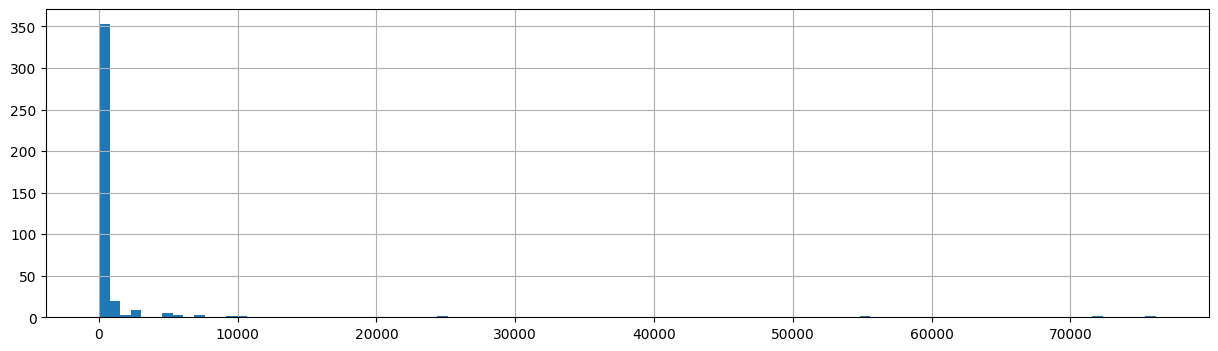

In [17]:
print(lit_main['n_CPGs'].describe())

lit_main['n_CPGs'].hist(bins=100, figsize=(15, 4))

In [18]:
lit_main.Sample_size_total.describe()

lit_main['n'] = pd.to_numeric(lit_main['Sample_size_total'], errors='coerce')

coerced_mask = lit_main['n'].isna() & lit_main['Sample_size_total'].notna()
lit_main.loc[coerced_mask , 'Sample_size_total']

91     Unclear
103    Unclear
139      >1000
191    Unclear
366    Unclear
394    Unclear
Name: Sample_size_total, dtype: object

count     752.000000
mean      354.277926
std       293.636751
min         5.000000
25%       222.000000
50%       222.000000
75%       332.000000
max      2597.000000
Name: n, dtype: float64


<Axes: >

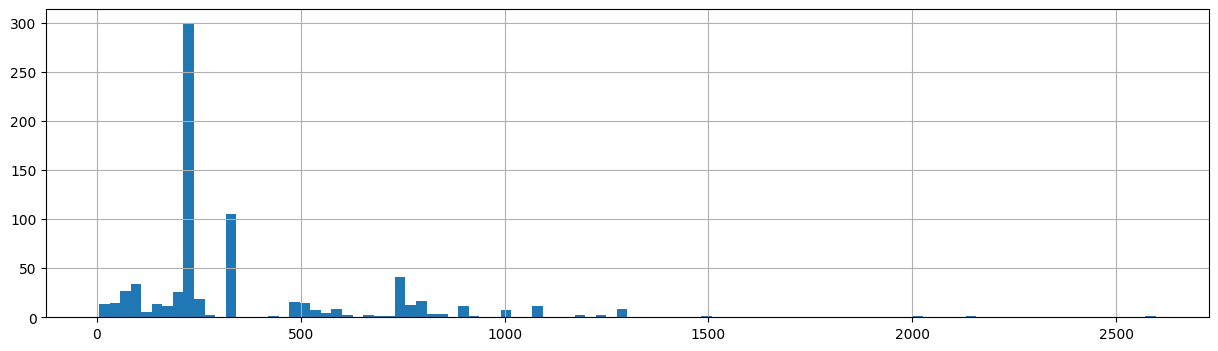

In [19]:
print(lit_main['n'].describe())

lit_main['n'].hist(bins=100, figsize=(15, 4))

In [20]:
from scipy.stats import spearmanr
r, p = spearmanr(lit_main['n'], lit_main['n_CPGs'], nan_policy='omit')

print('r =', round(r, 3), ', P = ', round(p,3))


r = -0.004 , P =  0.936


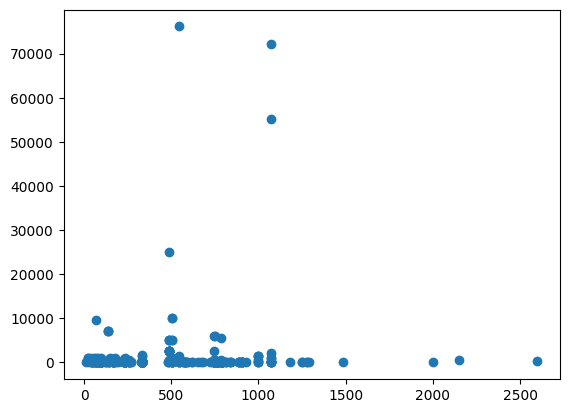

In [21]:
import matplotlib.pyplot as plt
plt.plot(lit_main['n'], lit_main['n_CPGs'], 'o')

###### Analytical methods

In [37]:
glit[['Title','n_MPS','Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5']].iloc[4]

Title               Association of Maternal Tobacco Use During Pre...
n_MPS                                                             4.0
Including_CpGs_1    [Association DNAm phenotype | Fixed p-value | ...
Including_CpGs_2    [nan, Biological relevance |functional annotat...
Including_CpGs_3                                                  NaN
Including_CpGs_4                                                  NaN
Including_CpGs_5                                                  NaN
Name: 4, dtype: object

In [22]:
lit_main[['Including_CpGs_1', 'Including_CpGs_2', 'Including_CpGs_3', 'Including_CpGs_4', 'Including_CpGs_5']]

lit_main.Including_CpGs_1.value_counts().sort_index()

Including_CpGs_1
Association DNAm phenotype | Actual change in methylation| 10%                                                                     7
Association DNAm phenotype | Actual change in methylation| 10-20%                                                                  8
Association DNAm phenotype | Actual change in methylation| 15%                                                                     5
Association DNAm phenotype | Actual change in methylation| 20%                                                                     2
Association DNAm phenotype | Actual change in methylation| 25%                                                                     1
Association DNAm phenotype | Actual change in methylation| 5%                                                                      4
Association DNAm phenotype | Actual change in methylation| 800                                                                     1
Association DNAm phenotype | Actual change in methyl

In [23]:
lit_main.Including_CpGs_2.value_counts().sort_index()

Including_CpGs_2
Association DNAm phenotype | AUC | ?                                         2
Association DNAm phenotype | AUC | top ranking ?                             1
Association DNAm phenotype | Actual change in methylation| 10%               5
Association DNAm phenotype | Actual change in methylation| >.4               2
Association DNAm phenotype | Actual change in methylation| ?                 1
Association DNAm phenotype | Fixed p-value | FDR < .01                       1
Association DNAm phenotype | Fixed p-value | not reported                    4
Association DNAm phenotype | effect size | D>1.3                             1
Association DNAm phenotype | logFC | >1                                      1
Association DNAm phenotype | top-ranking signifcant probes | 1000            8
Association DNAm phenotype | top-ranking signifcant probes | 800             3
Association DNAm phenotype | top-ranking signifcant probes | 900             2
Association DNAm phenotype | top-ra

In [24]:
lit_main.Including_CpGs_3.value_counts().sort_index()

Including_CpGs_3
Association DNAm phenotype | AUC | 333 highest                     1
Association DNAm phenotype | AUC | 500                             1
Association DNAm phenotype | AUC | 500 highest                     1
Association DNAm phenotype | AUC | = 1.00                          1
Association DNAm phenotype | AUC | > .80                          24
Association DNAm phenotype | AUC | > .90                           1
Association DNAm phenotype | AUC | >0.98                           1
Association DNAm phenotype | AUC | ?                              21
Association DNAm phenotype | AUC | top ranking 100-150            44
Association DNAm phenotype | AUC | top ranking 160                 1
Association DNAm phenotype | AUC | top ranking 200                 2
Association DNAm phenotype | AUC | top ranking 267                 1
Association DNAm phenotype | AUC | top ranking 300-500             1
Association DNAm phenotype | AUC | top ranking 400                 2
Association DNAm 

In [38]:
lit_main.Including_CpGs_4.value_counts().sort_index()

Including_CpGs_4
Association DNAm phenotype | AUC | = 1.00                                                                                             2
Association DNAm phenotype | AUC | top ranking 500                                                                                    1
Association DNAm phenotype | Actual change in methylation| 5%                                                                         2
Association DNAm phenotype | correlation | r>.4 (with lesion progression)                                                             1
Pruning | Pairwise correlation | 0.6                                                                                                  2
Pruning | Pairwise correlation | 0.60                                                                                                 1
Pruning | Pairwise correlation | 0.60-0.80                                                                                            1
Pruning | Pairwise correlation 

In [39]:
lit_main.Including_CpGs_5.value_counts().sort_index()

Including_CpGs_5
Association DNAm phenotype | Actual change in methylation| 5%     2
Biological relevance |functional annotation | Grouped to genes    1
Name: count, dtype: int64

In [41]:
lit_main.Determining_weights_1.value_counts().sort_index()

Determining_weights_1
Discovery EWAS | Count (+1 hyper, -1 hypo, based on linear regression)      4
Discovery EWAS | Survival analyses                                          1
Discovery EWAS | linear mixed model                                        18
Discovery EWAS | linear regression                                         76
Machine learning | Gradient boosting machine                                4
Machine learning | Naive bayes                                              1
Machine learning | Neural net                                               1
Machine learning | Random forest                                           10
Machine learning | Support vector machine                                 130
Penalized regression | ?                                                    1
Penalized regression | Elastic net                                        293
Penalized regression | Lasso                                                7
Penalized regression | Lassosum           

### Number of  Publications / MPSs per year

In [31]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Verdana"]

f0 = lit_main.groupby('Year').Title.nunique().plot(figsize=(10, 5), marker ='o', ms = 9, color='royalblue')

f0.set_xticklabels([int(x) for x in f0.get_xticks()], rotation=60)

f0.set_yticks([1]+[int(x) for x in range(5, 26, 5)])

# Set bin edges (1-year bins)
years = lit_main['Year']
min_year, max_year = years.min(), years.max()

# Histogram counts
counts, bin_edges = np.histogram(years, bins=np.arange(lit_main['Year'].min(), lit_main['Year'].max() + 2))  # +2 to include the last year)

# Scale counts to match 0-30 range to fit it on the same plot
max_count = counts.max()
scaled_counts = counts * (30 / max_count) if max_count > 0 else counts

nmps_bars = f0.bar(bin_edges[:-1],  # center the bars
                   scaled_counts,
                   width=0.4, color='pink', alpha=0.5, edgecolor=None, zorder=1, align='center')

for bar, count in zip(nmps_bars, counts):

    # Annotate each bar with the original count
    f0.text(bar.get_x() + bar.get_width()/2, 
            -3, # bar.get_height()+5, 
            str(count),
            ha='center', va='bottom', color='crimson', fontsize=10, 
            bbox=dict(boxstyle='round,pad=0.3',    # Rounded corners with padding
                      facecolor='pink', edgecolor='none', alpha=0.5))
    
f0.text(2025, -3, '*Number of MPSs', ha='center', va='bottom', fontsize=10, color='crimson', fontdict={'fontstyle':'italic'})

# Remove axes spines
for spine in f0.spines.values():
    spine.set_visible(False)

# Adjust y-axis 
f0.set_ylim(-10, 35)
f0.tick_params(axis='y', length=0, labelcolor='royalblue', labelsize=10)
f0.set_ylabel('Number of publications', fontsize=12, fontweight='bold', labelpad=10)
f0.grid(axis='y', color='royalblue', alpha=0.3)

# Adjust x-axis
f0.tick_params(axis='x', length=10, width=1, direction='in', color='black')
f0.hlines(-8.4, 2016.999, 2024, colors='black', linewidth=1)
f0.set_xlabel('Year', fontsize=12, fontweight='bold', labelpad=10)

f0.figure.savefig(f'../static_output/Figure0_MPS-pubs-per-year.png', dpi=300, bbox_inches='tight')

NameError: name 'plt' is not defined

### Publication network graph 

In [ ]:
import ast
import networkx as nx
import pickle

In [ ]:
G = nx.Graph()

for pub in glit.Title:             
    title = f"Paper/{pub.replace(':', ' ')}"
    authors = ast.literal_eval(glit.loc[glit.Title==pub, 'Author_list'].iloc[0])
    for author in authors:
        author = f"Author/{author.replace('. ', '.')}" # remove space between multiple initials   
        G.add_edge(author, title)


In [ ]:
# Estimate optimal node positions ----------------------------------------------------
# pos = nx.spring_layout(G, seed=3108, k=1000)
pos = nx.fruchterman_reingold_layout(G, seed=3108, k=0.05)

# Assign 'pos' attribute to the nodes in the graph
for node in G.nodes:
    G.nodes[node]['pos'] = pos[node]


In [ ]:
G.nodes

In [ ]:
# Save the graph object to a file
with open(f'{assets_directory}/Publications_network.pkl', 'wb') as file:
    pickle.dump(G, file)

In [ ]:
with open(f'{assets_directory}/Publications_network.pkl', 'rb') as file:
    G = pickle.load(file)

### Merge base and target info 

In [ ]:
d_base = pd.read_csv(f'{assets_directory}MPS_base_samples_cleaned.csv')

d_targ = lit_main.loc[lit_main.What_is_available != 'Only phenotype',]

print(d_targ.shape, d_base.shape)

In [ ]:
multi_base = d_targ.loc[d_targ.Identifier_base == "Multiple",]

multi_base_pubs = multi_base.Title.unique()
print(multi_base.shape[0], 'MPSs, from', len(multi_base_pubs), 'publications have multiple base samples.')

# d_targ.Multiple_identifier_base.value_counts()
multi_base.What_is_available.value_counts()

# TMP: remove them for now 
d_targ = d_targ.loc[d_targ.Identifier_base != "Multiple",]

d_targ.shape

In [ ]:
d_base['MPS_id'] = d_base['Identifier'] + d_base['Phenotype']
d_targ['MPS_id'] = d_targ['Identifier_base'] + d_targ['Phenotype']
# d_targ = d_targ.rename(columns={'Identifier_base': 'Identifier'})

common_ids = set(d_base['MPS_id']) & set(d_targ['MPS_id'])
unique_to_base = set(d_base['MPS_id']) - set(d_targ['MPS_id'])
unique_to_targ = set(d_targ['MPS_id']) - set(d_base['MPS_id'])

print(len(common_ids), "matching ids")
print(len(unique_to_base), "unique to base")
# print(unique_to_base)
print(len(unique_to_targ), "unique to targ")
# print(unique_to_targ)

# d_targ.loc[~d_targ.Multiple_identifier_base.isna(),]

In [ ]:
d_targ_base = d_targ.merge(d_base, on='MPS_id', how='left', suffixes=['_targ','_base'])
print(d_targ_base.columns)
d_targ_base.shape

# Save cleaned data ------------------------------------------------------------------
d_targ_base.to_csv(f'{assets_directory}MPS_base_target_cleaned.csv', index=False)

In [ ]:
# Merge BASE and TARGET data ---------------------------------------------------------
# d2_vars = ['Identifier', # 'Identifier_base', 'Multiple_identifier_base'
#            'Category', 'Phenotype', 
#            'Tissue',
#            'Array',
#            'Ancestry',
#            'Developmental_period', 
#            'Covariates']

# d1_vars = ['Identifier_base', # 'Multiple_identifier_base' ??
#            'Title', 'Year', 'What_is_available', 'Sample_overlap_target_base']+d2_vars[1:]

# # There is not overlap between BASE reference 
# # any([i in base_va.Identifier for i in  base_ss.Identifier])
# d_base = pd.concat([base_ss[d2_vars], base_va[d2_vars]], axis=0)
# d_base['MPS_id'] = d_base['Identifier'] + d_base['Phenotype']
# print(d_base.shape, '\n', list(d_base.columns))

# d_targ = lit.loc[lit.What_is_available != 'Only phenotype', d1_vars]
# d_targ['MPS_id'] = d_targ['Identifier_base'] + d_targ['Phenotype']
# d_targ = d_targ.rename(columns={'Identifier_base': 'Identifier'})

# print(d_targ.shape, '\n', list(d_targ.columns))

# # Merge info about target with info about base (for summary statistics)
# d = d_targ.merge(d_base, on='MPS_id',
#                  # left_on='Identifier_base', right_on='Identifier',
#                  how='left', suffixes=['_targ','_base'])

# # TMP: remove mismatches -------------------------------------------------------------
# mismatch = d.loc[d['Identifier_base'].isna(), ]
# d = d.loc[d['Identifier_base'].notna(), ] # Effectively inner join...
# d.shape


# Save cleaned data ------------------------------------------------------------------
# d.to_csv(f'{assets_directory}MPS_base_target.csv', index=False)

In [ ]:
mismatch


In [ ]:
# PROBLEMS 
# "Identifier_base" in the validated_algorithm - ignore? 

# What to do with the "multiple" bases ?  Excluded for now 
lit.loc[lit.Identifier_base == 'Multiple', ['Title', 'Multiple_identifier_base']]

# mismatch

# 21 mismatches... dropping them for now 
# Drop mismatches for now-- discuss with Is how to handle them 
# Richmond (2018) - DNA methylation as a marker --- does not match becasue two kinds of maternal smoking ...
# Gondolia (2019) - Methylome-wide association study provides --- not match because Air Polution vs PM 
# Stevenson (2021) - Creating and Validating a DNA --- IL6 vs IL-6: CHANGED IT 
# Levy (2022) - Novel diagnostic DNA methylation --- different disorders mismatch...?
# Awamleh (2022) - DNA methylation signature ass --- different syndromes?
# Portales-Casamar (2016) - DNA methylation sign --- fetal alcohol syndrome ONLY? or also prenatal alcohol exposure 
# Aref-Eshghi (2019) - Evaluation of DNA Methyla --- Genitopatellar syndrome (GTPTS) and Ohdo syndrome, SBBYSS variant (SBBYSS)...  matching wich?
# ...

# Identifier base == multiple. What do you mean, combined? 